In [23]:
# Credit card fraud - Logistic Regression

In [1]:
#The dataset contains transactions made by credit cards in September 2013 by European cardholders.
#This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 
#transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all 
#transactions.

#It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, 
#due to confidentiality issues, we cannot provide the original features and more background information about 
#the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have 
#not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each
#transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, 
#this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response
#variable and it takes value 1 in case of fraud and 0 otherwise. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm,skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression , Ridge, Lasso, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

import xgboost as xgb

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
df=pd.read_csv(r'C:\Users\david\Desktop\Curso ML\Pandas\creditcard.csv')

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
df.shape

(284807, 31)

In [11]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [29]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [15]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [17]:
# calculamos el porcentaje de cada uno de los datos

print((df.groupby(['Class'])['Class'].count()/df['Class'].count())*100)

Class
0    99.827251
1     0.172749
Name: Class, dtype: float64


([<matplotlib.patches.Wedge at 0x1e43ab10fb0>,
 [Text(-1.09998380137016, 0.0059696501784341355, ''),
  Text(1.0999838018177286, -0.005969567707642625, '')],
 [Text(-0.5999911643837235, 0.0032561728246004373, '99.8%'),
  Text(0.5999911646278518, -0.0032561278405323405, '0.2%')])

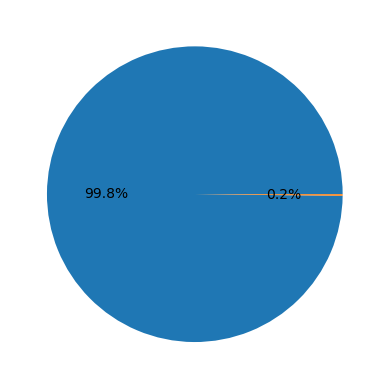

In [19]:
data=((df.groupby(['Class'])['Class'].count()/df['Class'].count())*100)
plt.pie(data,autopct='%1.1f%%')

In [23]:
# correlacion
corr=df.corr()
corr

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


<Axes: >

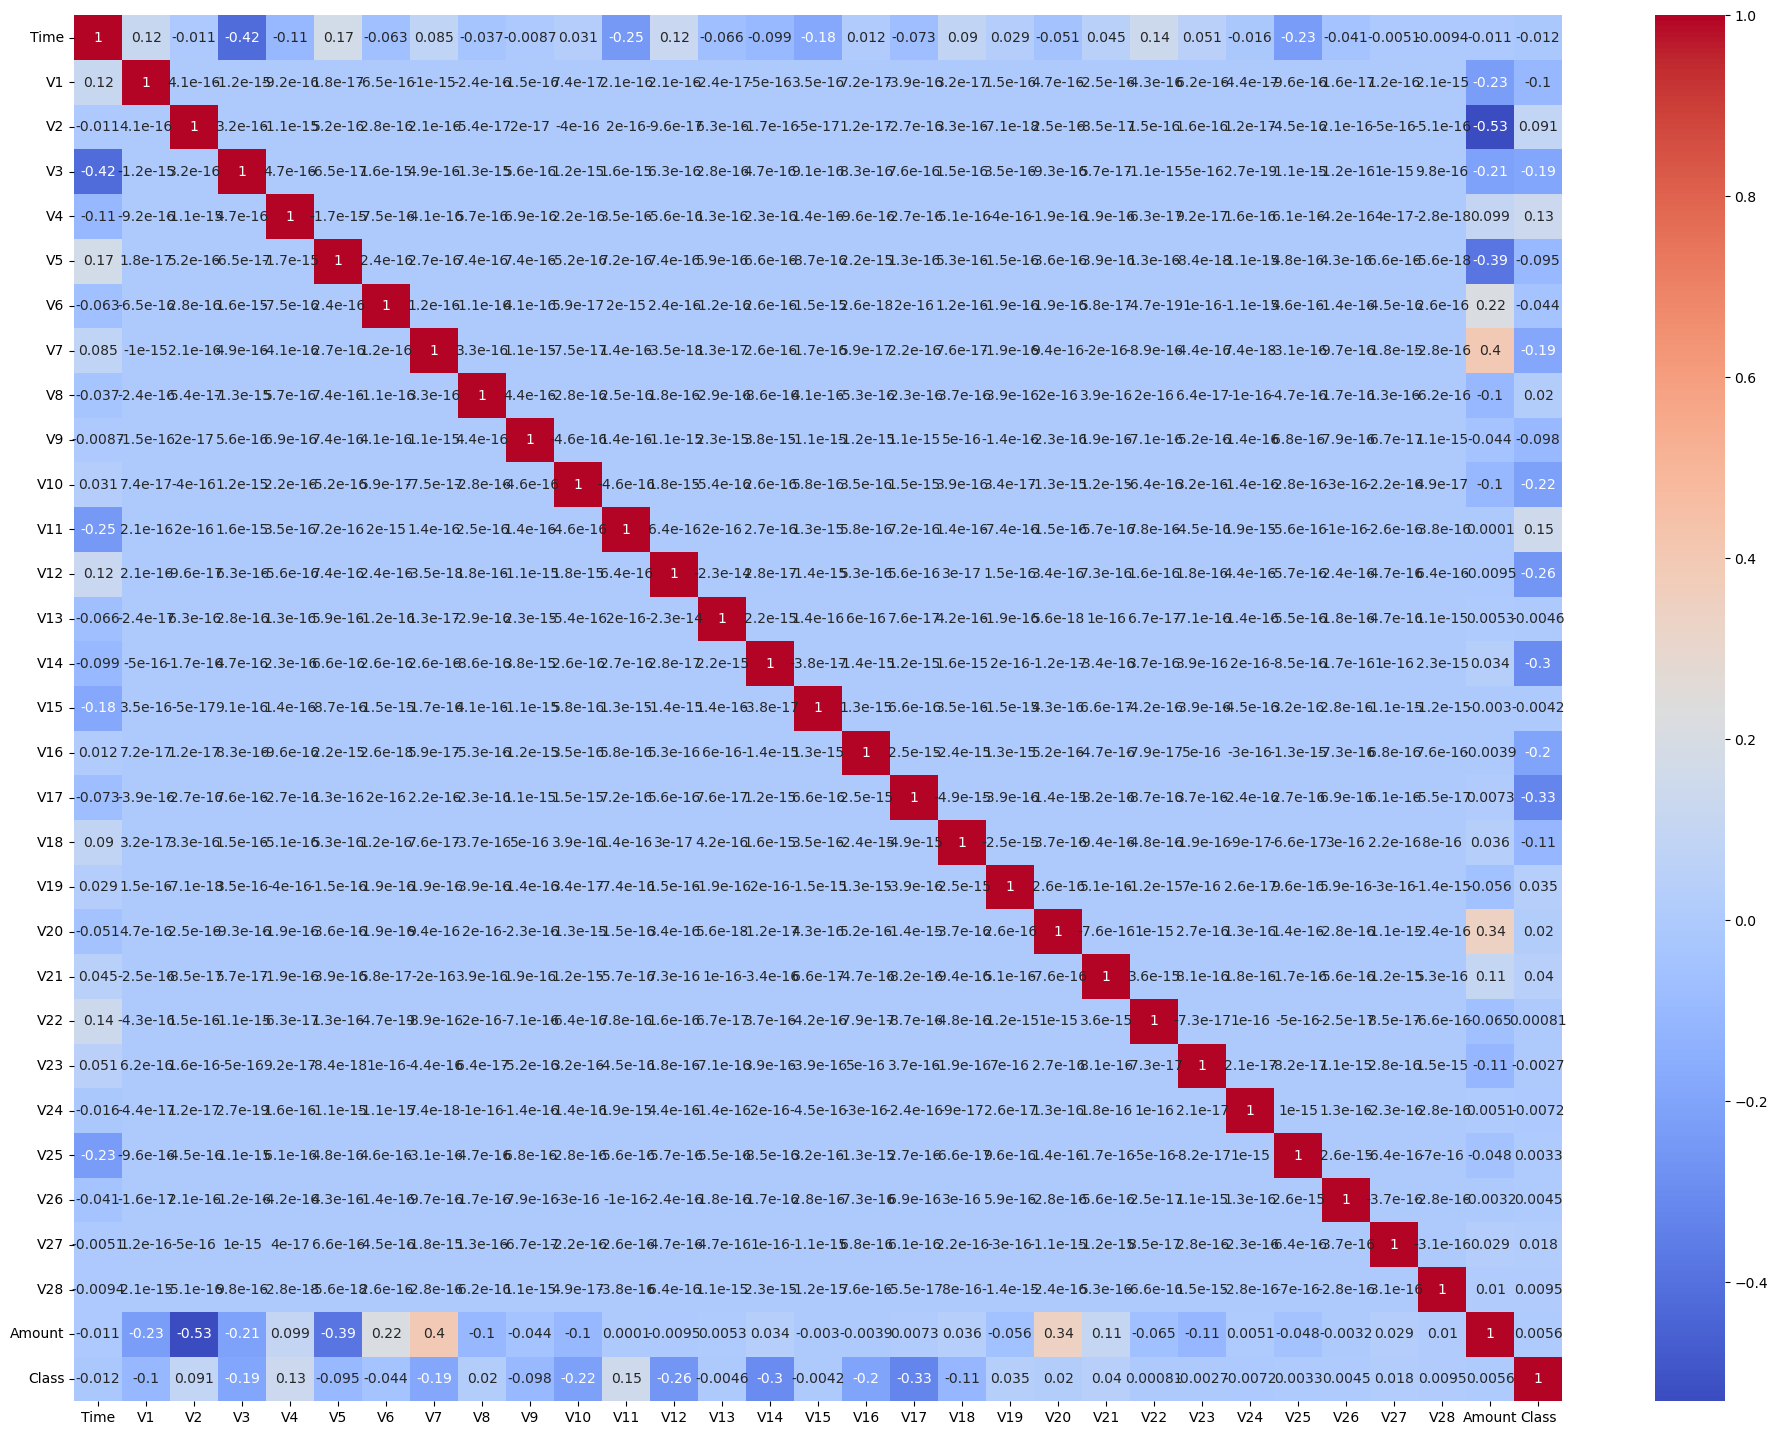

In [31]:
plt.figure(figsize=(24,18))
sns.heatmap(corr,annot=True,cmap='coolwarm')

In [27]:
# observamos una gran difercnia entre ambas--> el modelo no funcionaria bien
#0--> normal transaction
#1--> fraud transaction
# inbalanced dataset

In [33]:
legit=df.loc[df['Class']==0]
fraud=df.loc[df['Class']==1]

In [35]:
print(legit.shape,fraud.shape)

(284315, 31) (492, 31)


In [39]:
# analizamos estos datos
legit['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [41]:
fraud['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [43]:
#observamos como el promedio de cantidades de transacciones es mayor en fraud
# comparamos los valores de ambas transacciones
df.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


Under-sampling

In [47]:
# Construimos dataset  con distribución similar 
legit_sample=legit.sample(n=492) # toma 492 filas aleatorias de legit

In [49]:
print(legit_sample.shape,fraud.shape)

(492, 31) (492, 31)


In [51]:
# Unimos los dos df
new_df=pd.concat([legit_sample,fraud],axis=0)

In [57]:
new_df.head() # están colocados aleatoriamente

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
108530,70949.0,0.012196,0.300293,2.107374,1.149763,-0.810319,0.955415,-0.886787,-0.299679,0.398355,...,0.748715,-0.194962,-0.175797,-0.019629,0.842182,-0.193470,0.199328,0.185881,9.99,0
169801,119866.0,1.791467,-0.345818,-2.864434,0.248997,1.031363,-0.972006,1.227203,-0.564232,-0.265991,...,0.418647,1.038044,-0.482464,-0.692874,0.838364,0.132067,-0.107583,-0.070761,182.89,0
148805,90220.0,2.090796,-0.455943,-1.190350,-1.093970,-0.381631,-1.320087,-0.093655,-0.444173,3.251794,...,-0.046284,0.537573,0.009384,0.012386,0.267769,-0.090246,-0.025942,-0.069496,7.60,0
213373,139229.0,-0.573703,1.659140,1.516196,4.443381,0.107087,1.887702,-1.110310,-2.366664,-1.874059,...,-0.932010,1.562237,0.042655,0.699627,-0.734411,0.436951,0.255426,0.238093,37.83,0
26400,34047.0,0.747783,-0.830659,-0.104736,-0.501762,-0.828840,-0.495666,-0.141321,0.104118,1.353520,...,0.144049,0.157045,-0.257047,0.136013,0.443480,-0.645715,0.054511,0.076515,215.61,0


In [59]:
new_df['Class'].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

In [61]:
new_df.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,94990.648374,-0.049995,-0.097934,0.000970,0.149373,0.023717,0.036533,-0.065150,-0.098667,0.027255,...,-0.076682,0.039400,0.014035,0.018080,0.040589,0.008112,-0.032484,-0.016168,0.025034,93.078862
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


In [63]:
# vemos que no ha se ha modificado la naturaleza de los datos

In [71]:
# dividimos datos
X=new_df.drop(columns='Class', axis=1)
y=new_df['Class']

In [73]:
print(X.shape,y.shape)

(984, 30) (984,)


In [75]:
# realizamos split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=2, stratify=y)

In [77]:
# Presentamos el modelo

model=LogisticRegression()

In [79]:
# entrenamos el modelo
model.fit(X_train,y_train)

C:\Users\david\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [81]:
# evaluación del modelo
X_train_pred=model.predict(X_train)
accuracy_train=accuracy_score(X_train_pred,y_train)
print(accuracy_train)

0.9364675984752223


In [83]:
X_test_pred=model.predict(X_test)
accuracy_test=accuracy_score(X_test_pred,y_test)
print(accuracy_test)

0.9289340101522843


In [85]:
# sistema de predicción
datos=(0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,-0.166974414004614,1.61272666105479,1.06523531137287,0.48909501589608,-0.143772296441519,0.635558093258208,0.463917041022171,-0.114804663102346,-0.183361270123994,-0.145783041325259,-0.0690831352230203,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69)
datos_np=np.asarray(datos)
datos_np_reshape=datos_np.reshape(1,-1)

In [87]:
print(datos_np.shape,datos_np_reshape.shape)

(30,) (1, 30)


In [89]:
model.predict(datos_np_reshape)

C:\Users\david\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0], dtype=int64)